In [274]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [275]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fredapi import Fred
import requests
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

## Data Sources
In our research, we'll be using multiple sources of oil prices data for each of three regions that are discussed in the paper: United States, Russia and Middle East.
Data for US crude oil benchmark West Texas Intermediate (WTI) is coming from two main sources provided by the U.S. government. The first one is the Energy Information Administration (EIA), which gives us information about the crude oil prices, including prices for derived oil products such as gasoline, jet fuel, diesel, heating oil and propane. The second source is the Federal Reserve Economic Data, St. Louis (FRED), maintained by the Federal Reserve Bank of St. Louis. FRED provides economic time-series data.
The time-series is obtained through open data tools and Application Programming Interface (API).

Middle East region is represented by Dubai crude which is commonly used as benchmark for the pricing of Middle Eastern oil, consisting of Dubai, Oman or Abu Dhabi oil.

Russian oil is represented by Urals blend.

## Methodology

In order to analyze relations between oil and oil products we identified prices of crude oil and related oil products for three separate locations. Data was collected using RESTful API requests to query the government agencies sources such as EIA and IMF. In Python it's done with help of **requests** library allowing us to make the API calls with specified search parameters(time period, frequency, etc). 

In this study, we'll be focusing on the last five years, starting from October 2018 and going up to October 2023. We chose this time frame to assess how COVID-19, the Russia-Ukraine war, and Israel Hammas-Israel war affected petroleum prices. A five-year period provides a sufficiently large dataset for statistical analysis. This will allow us to perform the Exploratory Data Analysis(EDA) to draw meaningful conclusions about the relationships and correlations within the data. EDA is conducted using Python and popular data analysis libraries such as pandas, matplotlib, and seaborn. 

First, we imported oil prices into a Pandas DataFrame for easier work with tabular data. Next step was to organize data by combining all prices in one dataframe, naming columns and setting proper datatime index to manipulate the time-series. Subsequently, the data was inspected for missing values to ensure data quality. As a part of EDA to visualize the cleaned data, libraries  **matplotlib** and **seaborn** were used to illustrate how oil prices changed over time. The dataset contains prices for crude oil and petroleum products, to describe the relationships between them we conducted a correlation analysis by finding correlation coefficients and building correlation matrix. In our project we've plotted a heatmap to demonstrate how each oil product price correlates with others.

For further statistical analysis we calculated the daily returns on the prices and plotted the returns and the distribution of returns. Using returns instead of prices will make our series stationary, meaning that mean and variance does not change over time. To ensure the data stationarity we used Augmented Dickey-Fuller Test.
In addition to EDA we conducted Quantile-Quantile (Q-Q) analysis using **scipy** library to assess whether returns follow a particular theoretical distribution.

In next section we performed ARIMA modeling on crude oil prices to help us understand and predict how oil prices might change over time. By analyzing past prices relationships in different regions and influenced by geopolitical events, the model tries to identify trends and patterns that may repeat in the future. Predicting future prices is crucial for managing risks. We utilized Time Series Analysis module of the **statsmodels** Python package. ARIMA models allowed us to run only univariate time series modeling. Since we evaluate multiple variables in our dataset, multivariate techniques must be used to describe the relationships.

Therefore we applied Principal Component Analysis (PCA) to identify the patterns in the data. Machine learning library **scikit-learn** provides methods that we used to implement the PCA on the oil price data.







In [276]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'WTI Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start_date = '2018-10-01'
end_date = '2023-10-01'
date_range = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d')

oil_products_df = pd.DataFrame(date_range, columns=['period'])

for product in products: 
  # Query parameters 
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=desc&api_key=%s' % (product['code'], start_date, end_date, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])
  
  # Naming column with oil product name
  df.rename(columns={"value": product['name']}, inplace=True) 

  # Merging price series
  oil_products_df = pd.merge(oil_products_df, df[['period', product['name']]], on='period') 

In [277]:
# Setting proper index
oil_products_df['period'] = pd.to_datetime(df['period'])
oil_products_df.set_index('period', inplace=True)

# Convert oil products prices in $/gal to $/bbl multiplying by 42
# oil_products_df.iloc[:,1:6] = oil_products_df.iloc[:,1:6].multiply(42)

oil_products_df.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
period,,,,,,
2023-09-29,75.37,2.195,2.327,2.412,2.389,1.100
2023-09-28,75.16,2.204,2.317,2.397,2.372,1.075
2023-09-27,76.40,2.219,2.345,2.432,2.410,1.063
2023-09-26,74.44,2.189,2.312,2.399,2.379,1.035
2023-09-25,74.26,2.170,2.301,2.388,2.368,1.040


In [278]:
# Basic statistics of the dataset
oil_products_df.describe()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000
mean,66.325677,2.109614,2.142697,2.315250,2.212883,0.779687
std,20.828979,0.735616,0.851302,0.916478,0.877639,0.303088
min,-36.980000,0.434000,0.407000,0.602000,0.562000,0.203000
25%,53.307500,1.619750,1.700500,1.817750,1.747750,0.515000
50%,64.940000,2.049500,1.923000,2.066500,1.975500,0.719000
75%,79.570000,2.605500,2.627250,2.783750,2.617250,1.007000
max,123.640000,4.509000,5.066000,5.339000,5.152000,1.615000


In [279]:
# Check for missing values
oil_products_df.isna().value_counts()

WTI Crude  Gasoline  Jet Fuel  Diesel  Heating Oil  Propane
False      False     False     False   False        False      1256
dtype: int64

The dataset contains no NA values

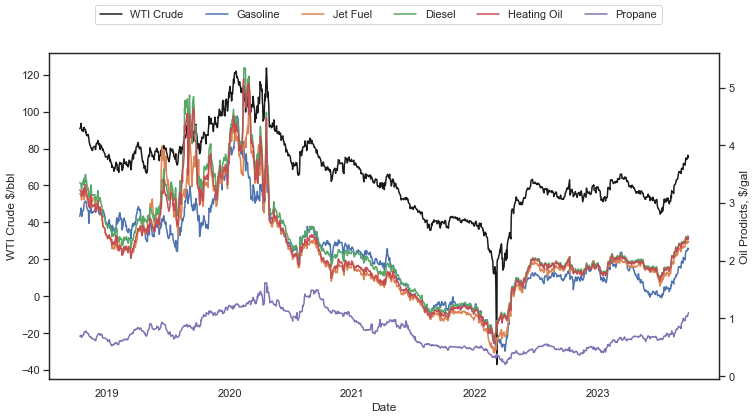

In [280]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the WTI Crude Oil prices on the left axis
ax1.set_xlabel('Date')
ax1.set_ylabel('WTI Crude $/bbl')

ax1.plot(oil_products_df.index, oil_products_df['WTI Crude'], color='k', label='WTI Crude')

# Plot the oil products prices on the right axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Prodicts, $/gal')
for column in ['Gasoline', 'Jet Fuel', 'Diesel', 'Heating Oil', 'Propane']:
  ax2.plot(oil_products_df.index, oil_products_df[column], label=column)

# Adjust the legend and show the plot
fig.legend(loc='upper center', ncol=len(oil_products_df.columns))
plt.show()

<AxesSubplot:>

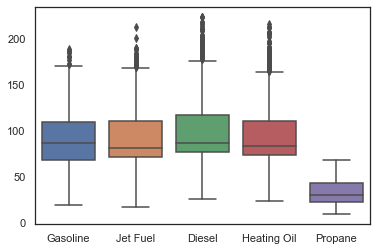

In [281]:
# Plotting blox plot to identify the outliers, oil products price was multipled by 42 to get comparable prices
sns.boxplot(data=oil_products_df.iloc[:,1:6].multiply(42))

In [282]:
# Estimating simple returns
wti_returns_df = oil_products_df.pct_change().dropna()
wti_returns_df.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
period,,,,,,
2023-09-28,-0.002786,0.004100,-0.004297,-0.006219,-0.007116,-0.022727
2023-09-27,0.016498,0.006806,0.012085,0.014602,0.016020,-0.011163
2023-09-26,-0.025654,-0.013520,-0.014072,-0.013569,-0.012863,-0.026341
2023-09-25,-0.002418,-0.008680,-0.004758,-0.004585,-0.004624,0.004831
2023-09-22,0.000135,0.002304,0.006084,0.001675,0.000845,0.000962


## Stationarity test

In [283]:
for product in wti_returns_df:
    print("\n", product)
    adf = adfuller(wti_returns_df[product])
    print("ADF Statistic: %f" % adf[0])
    print("p-value: %f" % adf[1])  
    


 WTI Crude
ADF Statistic: -11.077649
p-value: 0.000000

 Gasoline
ADF Statistic: -8.985153
p-value: 0.000000

 Jet Fuel
ADF Statistic: -16.921875
p-value: 0.000000

 Diesel
ADF Statistic: -14.358487
p-value: 0.000000

 Heating Oil
ADF Statistic: -25.449387
p-value: 0.000000

 Propane
ADF Statistic: -35.615987
p-value: 0.000000


Results of the tests show our data is stationary since p-values are extremely low.

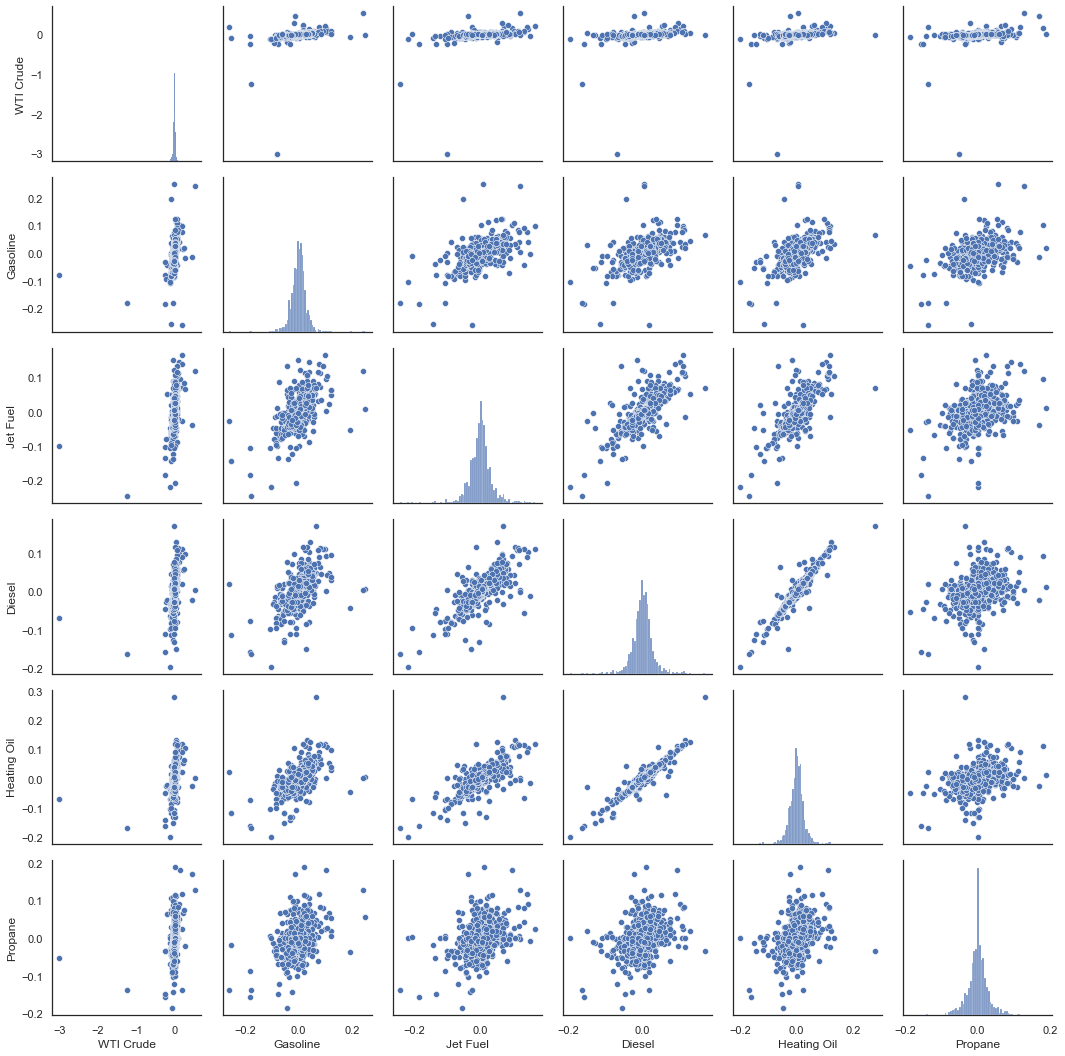

In [284]:
# Distribution of returns and scatterplots showing relationships between returns of various oil products
g = sns.PairGrid(wti_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## Key statistical metrics

In [285]:
# Creating empty DataFrame
stat_metrics = pd.DataFrame()

# Populating the dataframe with metrics
stat_metrics['Product'] = [item['name'] for item in products]
stat_metrics['Mean'] = wti_returns_df.mean().values
stat_metrics['Median'] = wti_returns_df.median().values
stat_metrics['Variance'] = wti_returns_df.var().values
stat_metrics['Skewness'] = stats.skew(wti_returns_df, axis=0, bias=True)
stat_metrics['Kurtosis'] = stats.kurtosis(wti_returns_df, axis=0, bias=True)

stat_metrics

,Product,Mean,Median,Variance,Skewness,Kurtosis
0,WTI Crude,-0.001947,0.001574,0.010033,-23.116553,674.445561
1,Gasoline,0.000711,0.001797,0.001037,-0.313281,15.046342
2,Jet Fuel,0.000847,0.001131,0.001187,-0.450418,7.278923
3,Diesel,0.000693,0.000962,0.000853,-0.366278,6.731837
4,Heating Oil,0.000725,0.000986,0.000969,0.111039,10.271881
5,Propane,0.000135,0.000000,0.001004,0.050325,5.755890


The distributions with a higher kurtosis have heavier tails.

In [286]:
wti_returns_df.cov()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
WTI Crude,0.010033,0.001036,0.001224,0.000931,0.000980,0.000790
Gasoline,0.001036,0.001037,0.000663,0.000564,0.000613,0.000422
Jet Fuel,0.001224,0.000663,0.001187,0.000809,0.000850,0.000432
Diesel,0.000931,0.000564,0.000809,0.000853,0.000867,0.000327
Heating Oil,0.000980,0.000613,0.000850,0.000867,0.000969,0.000345
Propane,0.000790,0.000422,0.000432,0.000327,0.000345,0.001004


In [287]:
# Calculate the correlation matrix
correlation_matrix = wti_returns_df.corr()
correlation_matrix.head()

,WTI Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
WTI Crude,1.000000,0.321283,0.354728,0.318105,0.314123,0.248803
Gasoline,0.321283,1.000000,0.597493,0.600196,0.611698,0.414015
Jet Fuel,0.354728,0.597493,1.000000,0.804222,0.791952,0.395736
Diesel,0.318105,0.600196,0.804222,1.000000,0.953792,0.353460
Heating Oil,0.314123,0.611698,0.791952,0.953792,1.000000,0.349304


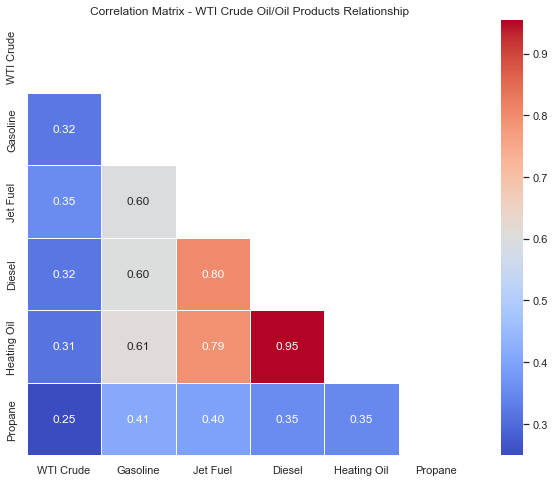

In [288]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Matrix - WTI Crude Oil/Oil Products Relationship')
plt.show()

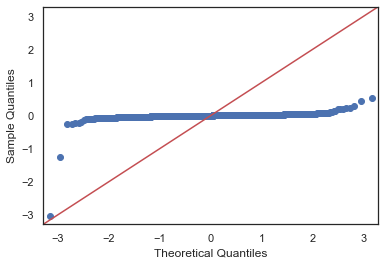

In [289]:
# Plot Q-Q plot
fig = sm.qqplot(wti_returns_df['WTI Crude'], line='45')
plt.show()

## Building ARIMA models

In [290]:
model = ARIMA(wti_returns_df['WTI Crude'], order=(3,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              WTI Crude   No. Observations:                 1255
Model:                 ARIMA(3, 1, 0)   Log Likelihood                1043.648
Date:                Sun, 19 Nov 2023   AIC                          -2079.296
Time:                        22:46:38   BIC                          -2058.760
Sample:                             0   HQIC                         -2071.577
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4408      0.006    -71.526      0.000      -0.453      -0.429
ar.L2         -0.4692      0.004   -116.493      0.000      -0.477      -0.461
ar.L3         -0.2679      0.005    -51.557      0.0

c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\timda\anaconda3\lib\site-

## Principal Components Analysis

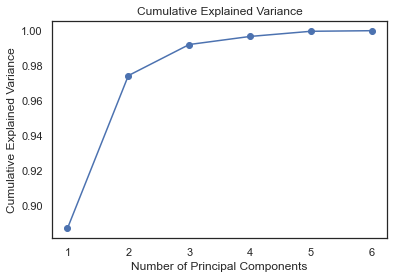

In [291]:
# Standardize the Data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(oil_products_df)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(data_standardized)

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [292]:
urals_df = pd.read_csv('data/urals_prices.csv', sep=';')
urals_df.head()

,09.11.2023,68.46
0,08.11.2023,68.41
1,07.11.2023,70.46
2,06.11.2023,74.04
3,03.11.2023,73.80
4,02.11.2023,74.46


<AxesSubplot:>

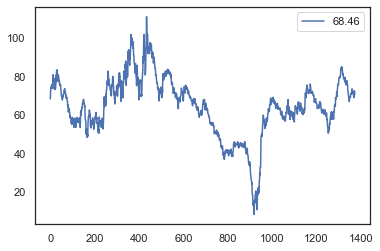

In [293]:
urals_df.plot()

## Dubai Crude prices in $ per barrel from International Monetary Fund API

In [294]:
# Obtaining Dubai Crude time-series from IMF using API query
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCPS/M.W00.POILDUB.USD'
data = (requests.get(url).json()
        ['CompactData']['DataSet']['Series'])

# Preparing the data
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
             for obs in data['Obs']]

# Create dataframe from array of dates and values
dubai_crude_df = pd.DataFrame(data_list, columns=['Date', 'Dubai Crude'])

# Setting datetime index
dubai_crude_df['Date'] = pd.to_datetime(dubai_crude_df['Date'])
dubai_crude_df.set_index(['Date'], inplace=True)

# Leaving 2 decimal palces
dubai_crude_df['Dubai Crude'] = dubai_crude_df['Dubai Crude'].astype(float).round(2)

dubai_crude_df.head()

,Dubai Crude
Date,
1990-01-01,17.50
1990-02-01,16.68
1990-03-01,15.76
1990-04-01,14.25
1990-05-01,14.65


In [295]:
# Checking for missing values
dubai_crude_df.isna().value_counts()

Dubai Crude
False          406
dtype: int64

<AxesSubplot:xlabel='Date'>

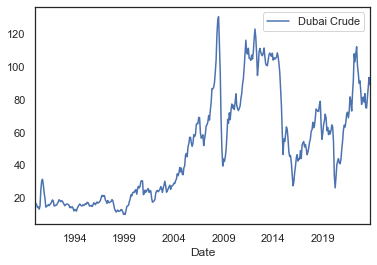

In [296]:
dubai_crude_df.plot()